In [26]:
import sys
sys.path.append("../..")

# Car Track Example

Track car state with Kalman filter and Rauch-Tung-Striebel smoother as in Examples 4.3 and 8.3 of the book Bayesian Filtering and Smoothing


## Imports

### Standard imports

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg

### Helpers imports

In [28]:
from python.common_utilities import generate_ssm, RandomState, rmse

### Plotting function

In [29]:
def plot(y, x1, label1, x2=None, label2=None):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(y[:, 0], y[:, 1], marker="o", label="Measurements", color="red")
    ax.plot(x1[:, 0], x1[:, 1], label=label1, color="blue")
    if x2 is None:
        ax.scatter(x1[0, 0], x1[0, 1], marker="*", color="orange", s=500)
    else:
        ax.plot(x2[:, 0], x2[:, 1], label=label2, color="orange")
    _ = ax.legend()
    _ = ax.set_xlabel("${\it x}_1$")
    _ = ax.set_ylabel("${\it y}_1$")

## Routine

Set the parameters:

In [30]:
q = 1.
dt = 0.1
s = 0.5

M = 4  # State dimension
N = 2  # Observation dimension

In [31]:
A = np.array([[1, 0, dt, 0],
              [0, 1, 0, dt],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])

In [32]:
Q = q * np.array([[dt ** 3 / 3, 0, dt ** 2 / 2, 0],
                  [0, dt **3 / 3, 0, dt ** 2 / 2],
                  [dt ** 2 / 2, 0, dt, 0],
                  [0, dt ** 2 / 2, 0, dt]])

In [33]:
H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])

In [34]:
R = np.array([[s ** 2, 0],
              [0, s ** 2]])

In [35]:
m_0 = np.array([0., 0., 1., -1.])
P_0 = np.array([[1, 0, 0, 0],
                [0, 1, 0, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1]])

## Simulate data

In [36]:
random_state = RandomState(33)
steps = 100

states, observations = generate_ssm(m_0, A, Q, H, R, steps, random_state)

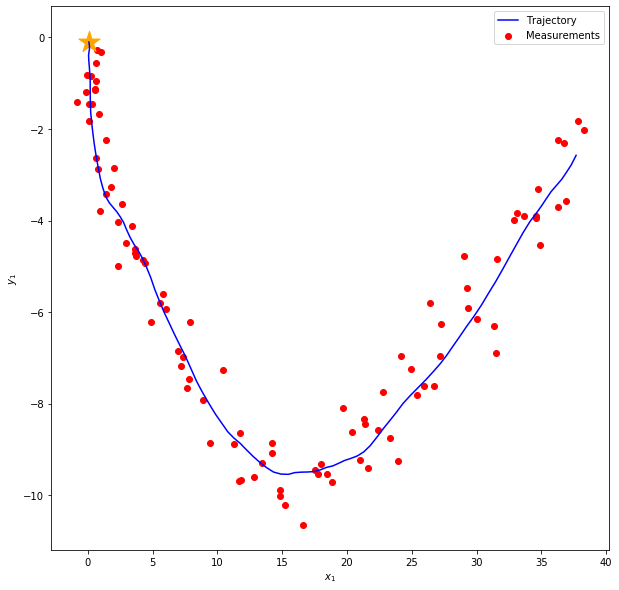

In [37]:
plot(observations, states, "Trajectory")

## Kalman Filter

In [38]:
def kalman_filter(m_0, P_0, A, Q, H, R, observations):
    M = m_0.shape[-1]
    steps, N = observations.shape
    
    kf_m = np.empty((steps, M))
    kf_P = np.empty((steps, M, M))
    
    m = m_0
    P = P_0
    
    for i in range(steps):
        observation = observations[i]
        m = A @ m
        P = A @ P @ A.T + Q
        
        S = H @ P @ H.T + R
        K = linalg.solve(S.T, H @ P.T, assume_a="pos").T 
        # More efficient and stable way of computing K = P @ H.T @ linalg.inv(S)
        # This also leverages the fact that S is known to be a positive definite matrix (assume_a="pos")
        
        m = m + K @ (observation - H @ m)
        P = P - K @ S @ K.T
        
        kf_m[i] = m
        kf_P[i] = P
    return kf_m, kf_P

In [39]:
kf_m, kf_P = kalman_filter(m_0, P_0, A, Q, H, R, observations)

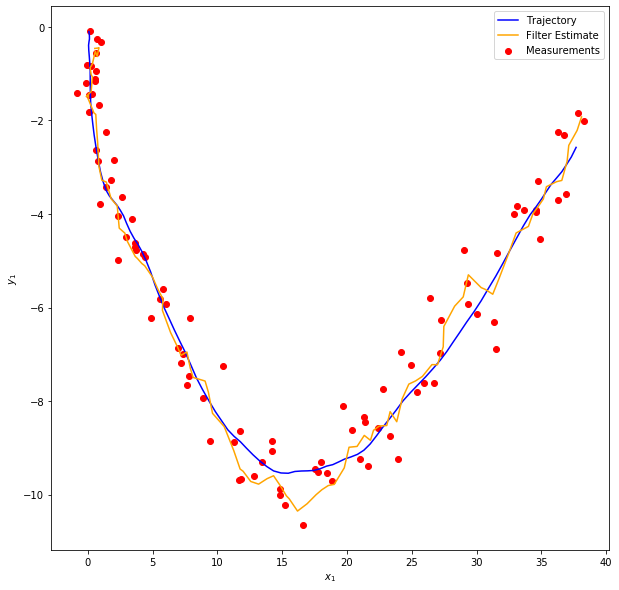

In [40]:
plot(observations, states, "Trajectory", kf_m, "Filter Estimate")

In [41]:
rmse_raw = rmse(states[:, :2], observations)
rmse_kf = rmse(kf_m[:, :2], states[:, :2])
print(f"RAW RMSE: {rmse_raw}")
print(f"KF RMSE: {rmse_kf}")

RAW RMSE: 0.7890852658072309
KF RMSE: 0.461445699282073


## RTS Smoother

In [42]:
def smoother(kf_m, kf_P, A, Q, H, R):
    steps, M = kf_m.shape
    
    rts_m = np.empty((steps, M))
    rts_P = np.empty((steps, M, M))
    
    m = kf_m[-1]
    P = kf_P[-1]
    
    rts_m[-1] = m
    rts_P[-1] = P
    
    for i in range(steps-2, -1, -1):
        filtered_m = kf_m[i]
        filtered_P = kf_P[i]
        
        mp = A @ filtered_m
        Pp = A @ filtered_P @ A.T + Q
        Ck = linalg.solve(Pp, A @ filtered_P.T, assume_a="pos").T 
        # More efficient and stable way of computing Ck = filtered_P @ A.T @ linalg.inv(Pp)
        # This also leverages the fact that Pp is known to be a positive definite matrix (assume_a="pos")

        m = filtered_m + Ck @ (m - mp)
        P = filtered_P + Ck @ (P - Pp) @ Ck.T
        
        rts_m[i] = m
        rts_P[i] = P

    return rts_m, rts_P

In [23]:
rts_m, rts_P = smoother(kf_m, kf_P, A, Q, H, R)

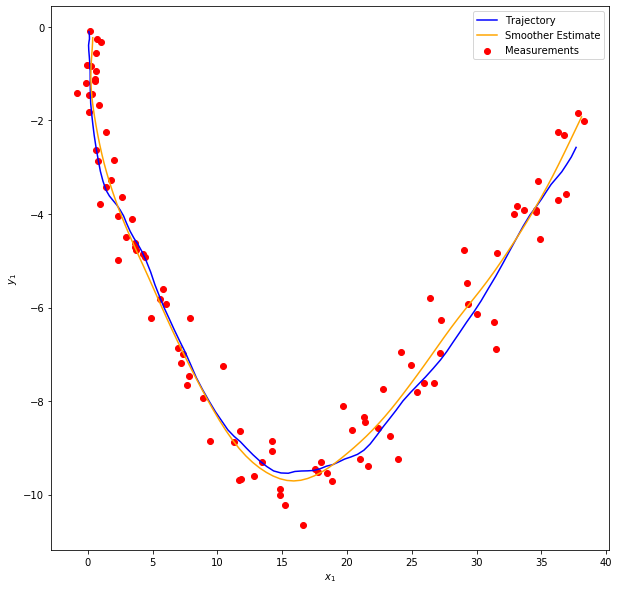

In [24]:
plot(observations, states, "Trajectory", rts_m, "Smoother Estimate")

In [25]:
rmse_rts = rmse(states[:, :2], rts_m[:, :2])
print(f"RTS RMSE: {rmse_rts}")

RTS RMSE: 0.25732839569614935
